In [1]:
# Importing the necessary libraries to be used for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import telegram

In [2]:
# Load the blood donation data categorized by state
url = 'https://raw.githubusercontent.com/MoH-Malaysia/data-darah-public/main/donations_state.csv'
df = pd.read_csv(url)

# Selecting only the necessary columns from df1
df = df[['date', 'state', 'daily', 'donations_new', 'donations_regular', 'donations_irregular']]\
    .rename(columns={'daily':'donations_total'})

# Splitting the dates by month and year
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Save date for the starting of collecting of data and the date of last update into a variable for later use
start_date = df.date.min()
end_date = df.date.max()

start_year = df.year.min()
end_year = df.year.max()

if '12-31' in str(end_date):
    last_complete_year = end_year
else:
    last_complete_year = end_year - 1
    
# Variable to store all savefigs, messages
figs = []
messages = []

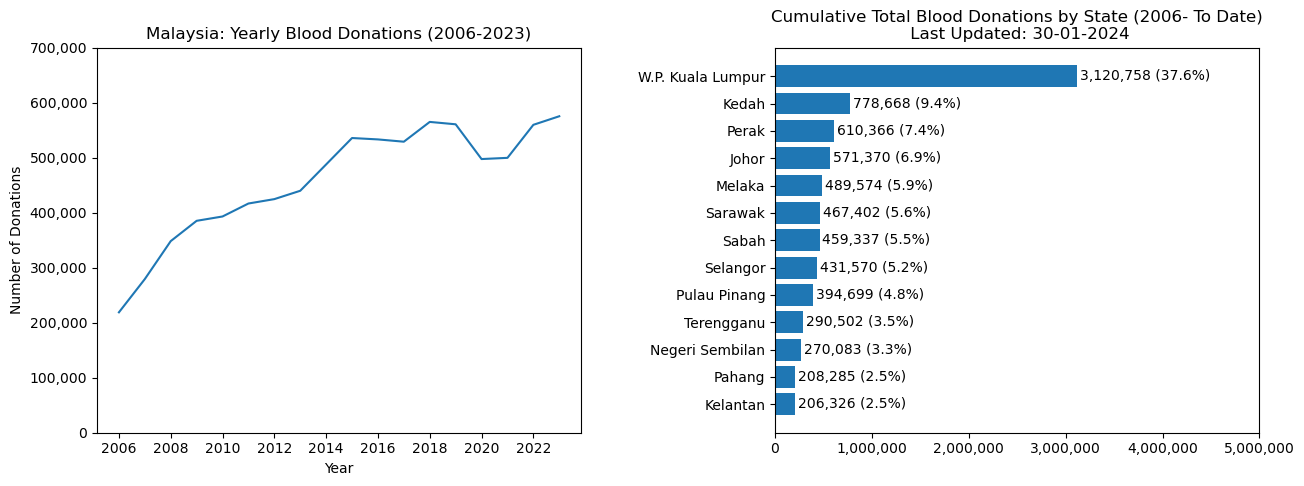

In [3]:
# Creating a dataframe that doesn't include state data and the total donations are summed annually
yearly = df[['year', 'state', 'donations_total']][df.state == 'Malaysia'].reset_index(drop=True)
yearly = yearly.groupby('year').sum(numeric_only=True).reset_index()

# Removing the final year if data isn't complete for the whole year
if last_complete_year != end_year:
    yearly = yearly[yearly['year'] != end_year].reset_index(drop=True)

# Creating a list of years to be used as axis labels     
years = yearly['year'].tolist()    

# Initial parameters
plt.figure(figsize=(15,5))

# First subplot 
ax1 = plt.subplot(1,2,1)
x = yearly['year']
y = yearly['donations_total']
plt.plot(x,y)

## Set x-axis parameters
ax1.set_xticks(np.arange(start_year, end_year, 2))

## Set y-axis parameters
ticks = list(range(0, 800000, 100000))
label = []
for tick in ticks:
    label.append('{:,}'.format(tick))
ax1.set_yticks(ticks)
ax1.set_yticklabels(label)

## Set annotations
plt.title('Malaysia: Yearly Blood Donations ({}-{})'.format(start_year, last_complete_year))
plt.xlabel('Year')
plt.ylabel('Number of Donations')

# Creating a dataframe categorized by state and compute cumulative donations to date for each state
state_total = df[['state', 'donations_total']][df.state != 'Malaysia'].reset_index(drop=True)
state_total = state_total.groupby('state').sum().reset_index()\
    .sort_values(by='donations_total')\
    .reset_index()

# Second subplot 
ax2 = plt.subplot(1,2,2)
x = state_total['state']
y = state_total['donations_total']
plt.barh(x,y)

## Set x-axis parameters
ticks = list(range(0,6000000,1000000)) 
label = []

for tick in ticks:
    label.append('{:,}'.format(tick))
ax2.set_xticks(ticks)
ax2.set_xticklabels(label)

## Set annotations
for i in range(0, len(x)):
    plt.text(y[i] + 30000, x[i], '{:,} ({}%)'.format(y[i], round(y[i]/y.sum()*100,1))\
             ,va='center', ha = 'left')

plt.title('Cumulative Total Blood Donations by State ('\
    + str(start_year) + '- To Date' + ')\n Last Updated: ' + str(end_date.strftime('%d-%m-%Y')))

## Adjust subplots
plt.subplots_adjust(wspace = 0.4)

fig1 = 'bd_analysis_fig1_q1.png'
plt.savefig(fig1, dpi=400)
figs.append(fig1)

msg1 = 'Malaysia\'s blood donation is trending up yearly. \
This is with the state of W.P. Kuala Lumpur being the largest contributor to the nation\'s blood bank. \
A dip is seen in 2019-2020, likely due to the COVID19 pandemic.'
messages.append(msg1)

plt.show()
plt.close()

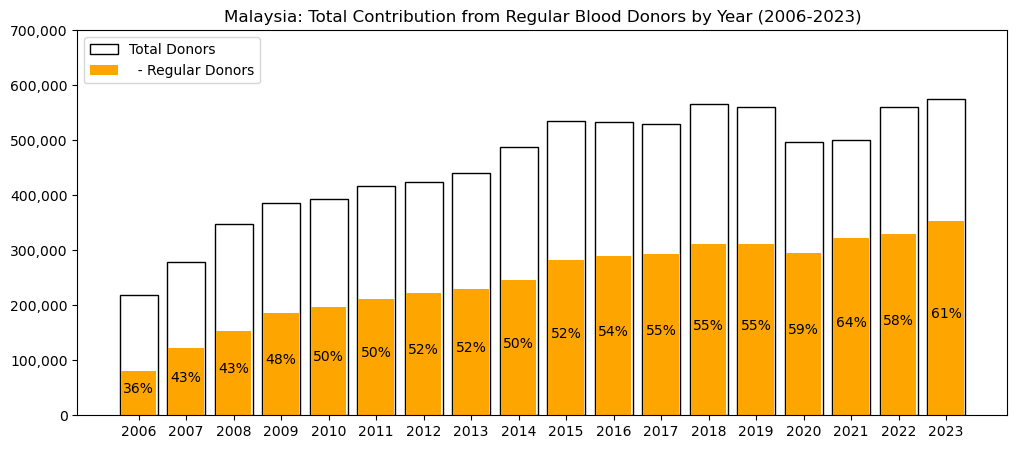

In [4]:
# Creating a dataframe to analyze the yearly contribution of regular donations to the total donations
tot_reg = df[['year', 'state', 'donations_total','donations_regular', 'donations_irregular', 'donations_new']][df.state == 'Malaysia'].reset_index(drop=True)
tot_reg = tot_reg.groupby('year').sum(numeric_only = True)\
    .reset_index()

if last_complete_year != end_year:
    tot_reg = tot_reg[tot_reg['year'] != end_year].reset_index(drop=True)

# Initial parameters 
plt.figure(figsize=(12,5))
ax = plt.subplot()

x = tot_reg['year']
y1 = tot_reg['donations_total']
y2 = tot_reg['donations_regular']

plt.bar(x, y1, bottom=0, color='white', edgecolor='black', label = 'Total Donors')
plt.bar(x, y2, color='orange', width=0.75, label = '  - Regular Donors')

## Set x-axis parameters
ax.set_xticks(range(start_year, last_complete_year+1))

## Set y-axis parameters
ticks = list(range(0, 800000, 100000))
label = []
for tick in ticks:
    label.append('{:,}'.format(tick))
ax.set_yticks(ticks)
ax.set_yticklabels(label)

## Set annotations
for i in range(0, len(x)):
    plt.text(x[i], y2[i]/2, str(int(y2[i]/y1[i]*100))+'%', ha='center')

plt.title('Malaysia: Total Contribution from Regular Blood Donors by Year ({}-{})'.format(start_year, last_complete_year))  
plt.legend(loc='upper left')   

fig2 = 'bd_analysis_fig2_q2.png'
plt.savefig(fig2, dpi=400)
figs.append(fig2)

msg2 = 'Since 2010, more than 50% of the nation\'s yearly contribution are from regular donors and it has been showing a steady trend up.'
messages.append(msg2)

plt.show()
plt.close()

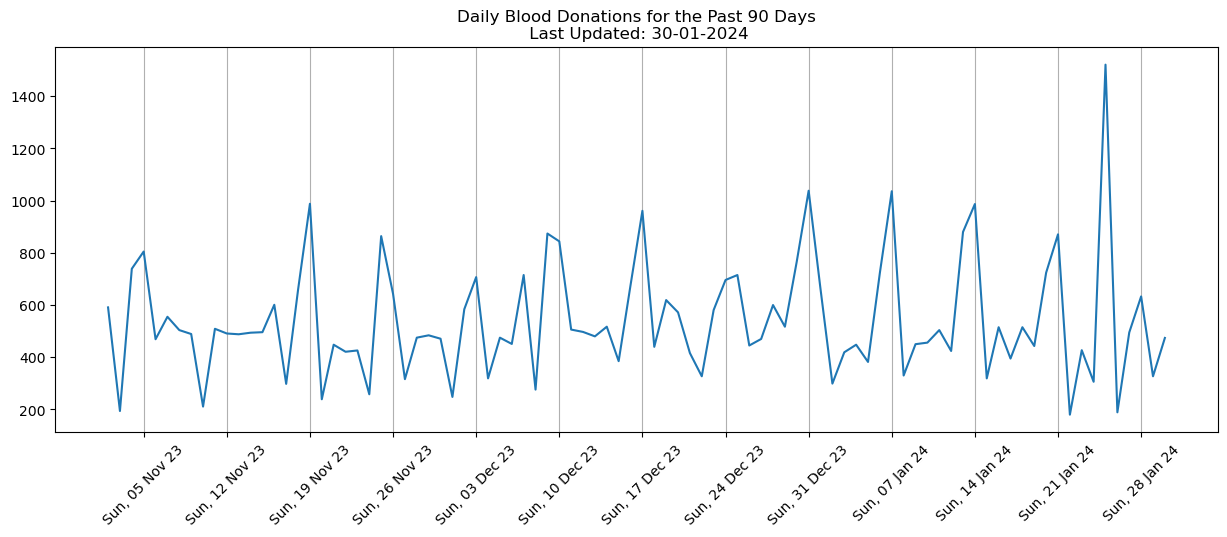

In [5]:
# Creating a dataframe to analyze the trend of blood donation for the past 90 days (by nation)
daily_past90d = df[['date', 'day', 'month', 'year', 'donations_total']]\
    .tail(90).reset_index(drop=True)

# Intial parameters
plt.figure(figsize= (15,5))
ax = plt.subplot()
x = daily_past90d['date']
y = daily_past90d['donations_total']
plt.plot(x,y)

## Set x-axis parameters
ticks = []
label = []

for date in daily_past90d['date']:
    if 'Sun' in date.strftime('%a, %d %b %y'):
        ticks.append(date)
        label.append(date.strftime('%a, %d %b %y'))        

ax.set_xticks(ticks)
ax.set_xticklabels(label, rotation = 45)

# Set annotations
plt.title('Daily Blood Donations for the Past 90 Days\n Last Updated: ' + str(end_date.strftime('%d-%m-%Y')))
plt.grid(axis='x')

fig3 = 'bd_analysis_fig3_additional.png'
plt.savefig(fig3, bbox_inches='tight', pad_inches=0.5, dpi=400)
figs.append(fig3)

msg3 = 'Blood donations are mostly the greatest on Sundays each week.'
messages.append(msg3)

plt.show()
plt.close()

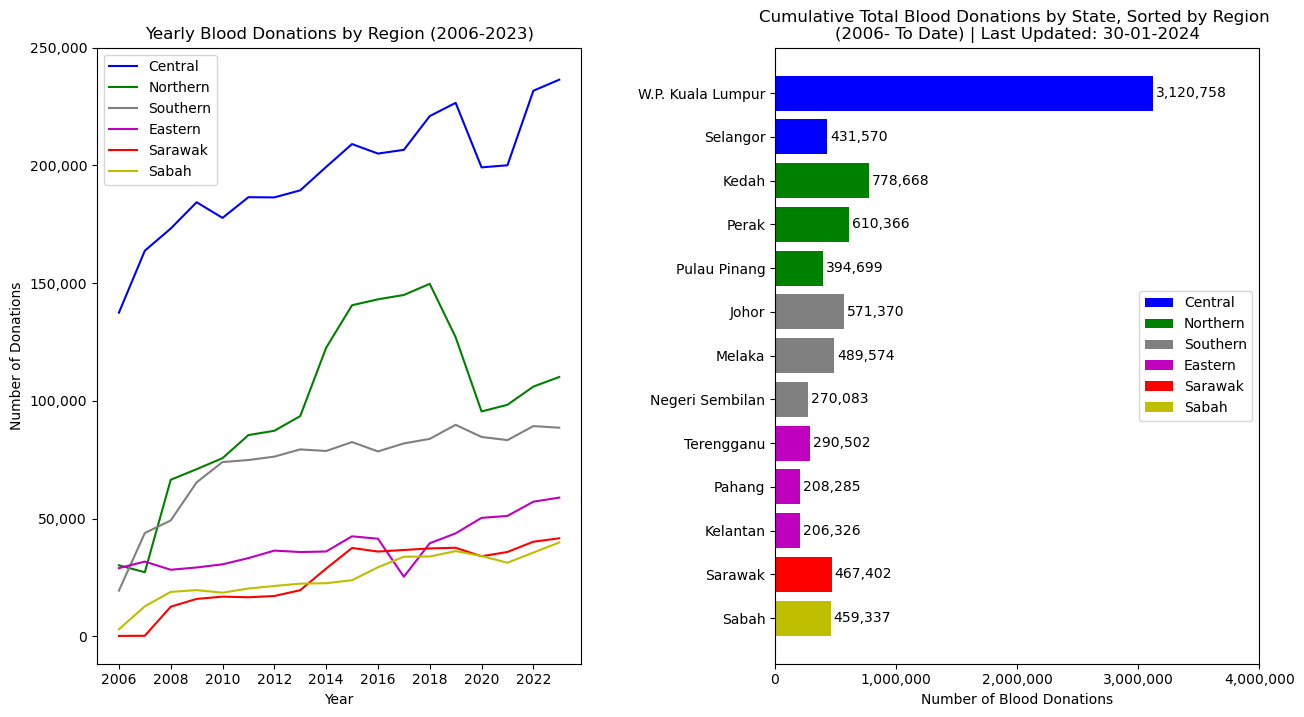

In [6]:
# Creating two dataframes to analyze blood donation of Malaysia and states separately
bd_states = df[df.state != 'Malaysia'].reset_index(drop=True)

# Creating a new column to categorize states based on region
regions = ['Central', 'Northern', 'Southern', 'Eastern', 'Sarawak', 'Sabah']
colours = ['b', 'g', 'grey', 'm', 'r', 'y' ]

conditions = [
    (bd_states['state'].isin(['Selangor', 'W.P. Kuala Lumpur'])),
    (bd_states['state'].isin(['Kedah', 'Pulau Pinang', 'Perak'])),
    (bd_states['state'].isin(['Johor', 'Melaka', 'Negeri Sembilan'])),
    (bd_states['state'].isin(['Pahang', 'Kelantan', 'Terengganu'])),
    (bd_states['state'] == 'Sarawak'),
    (bd_states['state'] == 'Sabah')
    ]

bd_states['colour'] = np.select(conditions, colours)
bd_states['region'] = np.select(conditions, regions)

# Grouping the states blood donation data by year and region
bd_region = bd_states.groupby(['region', 'colour', 'year']).sum(numeric_only=True)\
    .reset_index()\
    .drop(columns=['day', 'month'])

if last_complete_year != end_year:
    bd_region = bd_region[bd_region.year != end_year].reset_index(drop=True)
    
# Subplot 1
plt.figure(figsize=(15,8))

ax1 = plt.subplot(1,2,1)

# Iterating through the regions
for i in range(0,6):
    temp_df = bd_region[bd_region.region == regions[i]]\
        .reset_index()
    plt.plot(temp_df.year, temp_df.donations_total, label=regions[i], color=colours[i])

## Set x-axis parameters
ax1.set_xticks(np.arange(start_year, end_year, 2))

## Set y-axis parameters
ticks = list(range(0, 300000, 50000))
label = []
for tick in ticks:
    label.append('{:,}'.format(tick))
ax1.set_yticks(ticks)
ax1.set_yticklabels(label)

## Set annotations
plt.title('Yearly Blood Donations by Region ('+ str(start_year) + '-' + str(last_complete_year) + ')')
plt.xlabel('Year')
plt.ylabel('Number of Donations')
plt.legend(regions, loc=0)

total_bd_states = bd_states[['state', 'region', 'colour', 'donations_total']]\
    .groupby(['state', 'region', 'colour']).sum('donations_total')\
    .reset_index()\
    .sort_values(by=['colour', 'donations_total'], ascending = False)\
    .reset_index(drop=True)

total_bd_states['rank'] = total_bd_states.groupby(['region']).donations_total.rank(ascending=False)\
    .reset_index(drop=True)\

total_bd_states = total_bd_states.sort_values(by=['colour','rank'], ascending=False)\
    .reset_index(drop=True)

# Subplot 2 
ax2 = plt.subplot(1,2,2)

x = total_bd_states.state
y = total_bd_states.donations_total

plt.barh(x, y, color = total_bd_states.colour, label = total_bd_states.region)

## Set annotations
plt.title('Cumulative Total Blood Donations by State, Sorted by Region \n('\
    + str(start_year) + '- To Date' + ') | Last Updated: ' + str(end_date.strftime('%d-%m-%Y')))

plt.xlabel('Number of Blood Donations')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), reverse=True, loc='center right')

for i in range(0, len(x)):
    plt.text(y[i] + 25000, x[i], '{:,}'.format(y[i]), va='center', ha= 'left')

## Set x-axis parameters
ticks = list(range(0,5000000,1000000)) 
label = []

for tick in ticks:
    label.append('{:,}'.format(tick))
ax2.set_xticks(ticks)
ax2.set_xticklabels(label)

# Adjust subplots
plt.subplots_adjust(wspace = 0.4)

fig4 = 'bd_analysis_fig4_additional.png'
plt.savefig(fig4, dpi=400)
figs.append(fig4)

msg4 = ''
messages.append(msg4)

plt.show()
plt.close()

In [7]:
# Outputting results through telegram

bot_token = '6467599969:AAGA-qv99GVLc0-3jKKY4HXGZoTmZ98DBeA'
chat_id = '-4162931214'
bot = telegram.Bot(token=bot_token)

for photo_path, message in zip(figs, messages):
    bot.send_photo(chat_id=chat_id, photo=open(photo_path, 'rb'))
    if message != '':
        bot.sendMessage(chat_id=chat_id, text=message)